In [1]:
import pandas as pd
import numpy as np
from datetime import date
import re
import warnings

import feature_generation as fg
import imputation as imp
import evaluation as eva
import train_test_split as tts
import clf_define as clfd
import data_util as util

In [2]:
data = util.read_csv_data(r"D:\Project Data\MLHW3\projects_2012_2013.csv", {}, parse_dates=['date_posted', 'datefullyfunded'])

First of all, we will like to define our features and classifiers in the dataframe. In order to maintain the as much patterns as possible, we will only drop the columns with ids which include too much distinguish categories (more than 51) and information like logitude and latitude which can be categorized better using city and state. The number 51 is selected due to the number of state categories.

In [3]:
preserved_columns = []
for column in data.columns:
    if (data[column].dtype=='O') and (len(data[column].unique())<=51):
        preserved_columns.append(column)

In [4]:
print(preserved_columns)

['school_state', 'school_metro', 'school_charter', 'school_magnet', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'eligible_double_your_impact_match']


In [5]:
continuous_features = ['total_price_including_optional_support', 'students_reached']
categorical_features = set(preserved_columns) - set(continuous_features)

In [6]:
print(categorical_features)

{'resource_type', 'poverty_level', 'teacher_prefix', 'secondary_focus_subject', 'primary_focus_subject', 'school_metro', 'primary_focus_area', 'eligible_double_your_impact_match', 'school_state', 'school_charter', 'school_magnet', 'secondary_focus_area', 'grade_level'}


In [7]:
data[continuous_features + list(categorical_features)].head()

,total_price_including_optional_support,students_reached,resource_type,poverty_level,teacher_prefix,secondary_focus_subject,primary_focus_subject,school_metro,primary_focus_area,eligible_double_your_impact_match,school_state,school_charter,school_magnet,secondary_focus_area,grade_level
0,1498.61,31.0,Supplies,highest poverty,Mrs.,Visual Arts,Mathematics,urban,Math & Science,f,IL,f,f,Music & The Arts,Grades PreK-2
1,282.47,28.0,Books,highest poverty,Mrs.,Literature & Writing,Civics & Government,urban,History & Civics,t,CA,f,f,Literacy & Language,Grades 3-5
2,1012.38,56.0,Technology,high poverty,Ms.,Social Sciences,Literacy,urban,Literacy & Language,f,CA,f,f,History & Civics,Grades 3-5
3,175.33,23.0,Books,high poverty,Ms.,NaN,Literacy,urban,Literacy & Language,f,NY,f,t,NaN,Grades PreK-2
4,3591.11,150.0,Technology,high poverty,Mrs.,Literature & Writing,Literacy,suburban,Literacy & Language,f,NY,f,f,Literacy & Language,Grades PreK-2


We label 1 to the project which are not funded in 60 days right after they are posted, and label 0 to those who are funded in 60 days right after it is posted.

In [8]:
data['duration'] = data["datefullyfunded"] - data["date_posted"]
data['classifier'] =  np.where(data['duration'] > pd.Timedelta('60 days'), 1, 0)

In [9]:
classifier = "classifier"
data["classifier"].head()

0    0
1    0
2    1
3    0
4    1
Name: classifier, dtype: int32

We then move on to split the dataframe to train and test sets with rolling windows stratefy in this case. I split the dataframe with time unit of half years cutoff which is at date 6/30 and 12/31. For every training data set, there will remain 60 days gap for the result (label) of the outcome (classifier) to be observed. The testing set will be set as half year (might be shorter in the last test set) right after the gap.

In [10]:
half_year_stamp = [(1,1), (7,1)]
start_date = pd.Timestamp('2012-01-01 00:00:00')
end_date = pd.Timestamp('2014-01-01 00:00:00')

time_cutoff lists includes the start date, one day after the end dates and other cutoff dates, time interval will be defined as the date between them (including the lower but not include the upper bound).

In [11]:
time_cutoffs = tts.gen_time_cuts(start_date, end_date, half_year_stamp)
print(sorted(time_cutoffs))

[Timestamp('2012-01-01 00:00:00'), Timestamp('2012-07-01 00:00:00'), Timestamp('2013-01-01 00:00:00'), Timestamp('2013-07-01 00:00:00'), Timestamp('2014-01-01 00:00:00')]


I use define_time_variables to create the indicators for rolling window split in this case, taking waiting times (60 days) into account. All train dataframe starts in 2012-01-01 but the testing data starts at 2012-07-01 + (60 days), 2013-01-01 + (60 days), 2013-07-01 + (60 days) respectively.

In [12]:
data = tts.define_time_variables(data, pd.Timedelta('183 days'), pd.Timedelta('60 days'), "date_posted", "datefullyfunded", start_date, end_date, half_year_stamp)

In [13]:
data[data["tmp_label0"] == "train"]["date_posted"].sort_values(ascending=True).head()

69180   2012-01-01
32005   2012-01-01
38220   2012-01-01
74297   2012-01-01
21950   2012-01-01
Name: date_posted, dtype: datetime64[ns]

In [14]:
data[data["tmp_label0"] == "test"]["date_posted"].sort_values(ascending=True).head()

16332    2012-08-30
60107    2012-08-30
71880    2012-08-30
107093   2012-08-30
107156   2012-08-30
Name: date_posted, dtype: datetime64[ns]

In [15]:
data[data["tmp_label1"] == "train"]["date_posted"].sort_values(ascending=True).head()

72487    2012-01-01
63421    2012-01-01
117377   2012-01-01
62941    2012-01-01
117198   2012-01-01
Name: date_posted, dtype: datetime64[ns]

In [16]:
data[data["tmp_label1"] == "test"]["date_posted"].sort_values(ascending=True).head()

121525   2013-03-02
37673    2013-03-02
3158     2013-03-02
108509   2013-03-02
30275    2013-03-02
Name: date_posted, dtype: datetime64[ns]

In [17]:
data[data["tmp_label2"] == "train"]["date_posted"].sort_values(ascending=True).head()

63675    2012-01-01
114946   2012-01-01
48094    2012-01-01
50966    2012-01-01
107459   2012-01-01
Name: date_posted, dtype: datetime64[ns]

In [18]:
data[data["tmp_label2"] == "test"]["date_posted"].sort_values(ascending=True).head()

66491    2013-08-30
121728   2013-08-30
15134    2013-08-30
111442   2013-08-30
93247    2013-08-30
Name: date_posted, dtype: datetime64[ns]

The data is then be splitted according to the time_split_indicators

In [19]:
time_split_indicators = ["tmp_label0", "tmp_label1", "tmp_label2"]

In [20]:
data_dict = tts.rolling_window_split(data, time_split_indicators, list(categorical_features) + continuous_features, classifier)

We than move on to the imputation of missing values in the data of each sub set, we used the trained infromation in the training dataframe is used it in the transformation in the corresponding test dataframe. We will used different strategies with different missing values in the dataframe. For the categorical variables, we will use a "unknown" category to replace the unknown values. (Using fill_unknown) For the continuous variable, we will use the group mean of the training data to impute both training and testing dataframe. (Using fill_na_mean) 

We can observe several missing values in the given dataframe after rolling window split, we do not want to include classifier in the imputation since labeling unknown classification will be problematic with distribution taht we are not sure.

In [21]:
for idx, dat in data_dict.items():
    train_X, train_y, test_X, test_y = dat
    print("missing in training " + idx)
    print(imp.summarize_missing_values(train_X))
    print("missing in testing " + idx)
    print(imp.summarize_missing_values(test_X))
    print("           ")

missing in training tmp_label0
{'resource_type': (2, 26386), 'poverty_level': (0, 26386), 'total_price_including_optional_support': (0, 26386), 'teacher_prefix': (0, 26386), 'primary_focus_subject': (2, 26386), 'primary_focus_area': (2, 26386), 'school_metro': (2643, 26386), 'school_state': (0, 26386), 'school_charter': (0, 26386), 'school_magnet': (0, 26386), 'students_reached': (4, 26386), 'secondary_focus_area': (8524, 26386), 'eligible_double_your_impact_match': (0, 26386), 'grade_level': (1, 26386), 'secondary_focus_subject': (8524, 26386)}
missing in testing tmp_label0
{'resource_type': (5, 33357), 'poverty_level': (0, 33357), 'total_price_including_optional_support': (0, 33357), 'teacher_prefix': (0, 33357), 'primary_focus_subject': (4, 33357), 'primary_focus_area': (4, 33357), 'school_metro': (4015, 33357), 'school_state': (0, 33357), 'school_charter': (0, 33357), 'school_magnet': (0, 33357), 'students_reached': (22, 33357), 'secondary_focus_area': (11045, 33357), 'eligible_dou

In [22]:
imp_data_dict = {}
for idx, dat in data_dict.items():
    train_X, train_y, test_X, test_y = dat
    train_X, test_X = imp.fill_na_mean(train_X, test_X, continuous_features)
    train_X, test_X = imp.fill_unknown(train_X, test_X, categorical_features)
    imp_data_dict[idx] = [train_X, train_y, test_X, test_y]

We can observe that after the imputation the new_data_dict contains no missing values in the training and testing subsets

In [23]:
for idx, dat in imp_data_dict.items():
    train_X, train_y, test_X, test_y = dat
    print("missing in training " + idx)
    print(imp.summarize_missing_values(train_X))
    print("missing in testing " + idx)
    print(imp.summarize_missing_values(test_X))
    print("           ")

missing in training tmp_label0
{'resource_type': (0, 26386), 'poverty_level': (0, 26386), 'total_price_including_optional_support': (0, 26386), 'teacher_prefix': (0, 26386), 'primary_focus_subject': (0, 26386), 'primary_focus_area': (0, 26386), 'school_metro': (0, 26386), 'school_state': (0, 26386), 'school_charter': (0, 26386), 'school_magnet': (0, 26386), 'students_reached': (0, 26386), 'secondary_focus_area': (0, 26386), 'eligible_double_your_impact_match': (0, 26386), 'grade_level': (0, 26386), 'secondary_focus_subject': (0, 26386)}
missing in testing tmp_label0
{'resource_type': (0, 33357), 'poverty_level': (0, 33357), 'total_price_including_optional_support': (0, 33357), 'teacher_prefix': (0, 33357), 'primary_focus_subject': (0, 33357), 'primary_focus_area': (0, 33357), 'school_metro': (0, 33357), 'school_state': (0, 33357), 'school_charter': (0, 33357), 'school_magnet': (0, 33357), 'students_reached': (0, 33357), 'secondary_focus_area': (0, 33357), 'eligible_double_your_impact_m

After I impute the missing values, I move on to feature generations. In this process, the features generated in the training dataframe have to be consistant to the features in testing dataframe. All categorical variables in the selected features will be transformed to binary features and all continuous variables will be transformed to scaled continuous using MaxMinScale

In [24]:
ft_data_dict = {}
for idx, dat in imp_data_dict.items():
    train_X, train_y, test_X, test_y = dat
    train_X, test_X = fg.min_max_transformation(train_X, test_X, continuous_features)
    ft_data_dict[idx] = [train_X, train_y, test_X, test_y]

In [25]:
ft_data_dict2 = {}
for idx, dat in ft_data_dict.items():
    train_X, train_y, test_X, test_y = dat
    for cat_column in categorical_features:
        train_X, test_X = fg.category_to_binary(train_X, test_X, cat_column)
    ft_data_dict2[idx] = [train_X, train_y, test_X, test_y]

We then define the final dictionary of data using for machine learning pipeline as ft_data_dict2

In [26]:
data_dict = ft_data_dict2

We then begin the training and evaluation process of the data, we will use different methods, different proportion of the populations we might concern, and also conduct cross_validation in the following training and evaluation process. 

Due to the time concern of training models, I will define the models with differnt priorities. Low priority model will only be trained in the simple grid, the medium priority models will be trained in simple and small grid, and high priority models will the trained in all of the grids. The model with their corresponding priorities are presented as the following.
1. Low priority: KNN, Naive Bayes, SVM
2. Medium priority: Bagging, Adaboost, Gradient Boosting, Extra Trees
3. High priority: Decision Tree, Random Forest, Logistics

Note that in the threshold column in performance matrix, the value is represents the percentile of the predicted probability from the given classifiers. I sort the values of the score (or probability) and define the threshold with the given percentile, any score which is higher than the threshold will then be classified as 1. The design is corresponding to the x-axis in precision-recall curve ("percent of population labelled 1 in prediction") when we care about the percent of population with the highest risks.
0. percentile = 100% , percent of population labelled 1 in prediction: 0%
1. percentile = 99% , percent of population labelled 1 in prediction: 1%
2. percentile = 98% , percent of population labelled 1 in prediction: 2%
3. percentile = 95% , percent of population labelled 1 in prediction: 5%
4. percentile = 90% , percent of population labelled 1 in prediction: 10%
5. percentile = 80% , percent of population labelled 1 in prediction: 20%
6. percentile = 70% , percent of population labelled 1 in prediction: 30%
7. percentile = 60% , percent of population labelled 1 in prediction: 40%
8. percentile = 50% , percent of population labelled 1 in prediction: 50%
9. percentile = 0% , percent of population labelled 1 in prediction: 100%

Notice that if percent of population labelled 1 in prediction is 100%, we can estimate the baseline prediction of precision with base strategy to predict 1 for all rows.

Due to the time limit in model training, I will train the high priority in the small grid. And the performance matrix over time is presented below. We can specify other models with a larger grid and specify more threshold in the threshold list if necessary in the model.

In [31]:
sub_small = {'decision_tree': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
    'random_forest':{'n_estimators': [1, 10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10]},
    'logistics': {'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]}}

In [ ]:
warnings.filterwarnings("ignore")
cross_val_performance_test_simple = clfd.cross_validate_performance(clfd.clfs, small, data_dict, [0.95], \
                                ["accuracy", "f1", "recall", "precision", "AUC_ROC"], pr_curve=True)

In [50]:
ct = cross_val_performance_test_simple.reset_index(drop=True)

We then find the model with the parameters that perform the best, which is random forest with the parameters presented as below.

In [68]:
best_para = ct.sort_values(by="precision", ascending=False).iloc[0].parameters

In [69]:
best_para

"random_forest with parameters : {'min_samples_split': 10, 'n_jobs': 2, 'class_weight': None, 'random_state': None, 'min_impurity_decrease': 0.0, 'oob_score': False, 'n_estimators': 100, 'verbose': 0, 'criterion': 'gini', 'max_leaf_nodes': None, 'max_depth': 50, 'min_samples_leaf': 1, 'min_impurity_split': None, 'warm_start': False, 'min_weight_fraction_leaf': 0.0, 'max_features': 'sqrt', 'bootstrap': True}"

The best performance for logistics and decision tree is presented as following as references.

In [80]:
ct[(ct.method=="logistics") & (ct.cross_validate_index=="tmp_label2")].sort_values(by="precision", ascending=False).iloc[0]

method                                                          logistics
accuracy                                                         0.715221
f1                                                               0.129032
recall                                                          0.0761655
precision                                                        0.421818
AUC_ROC                                                          0.564972
threshold                                                            0.95
parameters              logistics with parameters : {'solver': 'warn',...
cross_validate_index                                           tmp_label2
Name: 182, dtype: object

In [81]:
ct[(ct.method=="decision_tree") & (ct.cross_validate_index=="tmp_label2")].sort_values(by="precision", ascending=False).iloc[0]

method                                                      decision_tree
accuracy                                                         0.713433
f1                                                               0.117592
recall                                                          0.0689429
precision                                                        0.399493
AUC_ROC                                                          0.648682
threshold                                                            0.95
parameters              decision_tree with parameters : {'min_samples_...
cross_validate_index                                           tmp_label2
Name: 146, dtype: object

In [82]:
ct[(ct.method=="random_forest") & (ct.cross_validate_index=="tmp_label2")].sort_values(by="precision", ascending=False).iloc[0]

method                                                      random_forest
accuracy                                                         0.718525
f1                                                               0.134241
recall                                                          0.0787919
precision                                                        0.453115
AUC_ROC                                                          0.531754
threshold                                                            0.95
parameters              random_forest with parameters : {'min_samples_...
cross_validate_index                                           tmp_label2
Name: 186, dtype: object

We then focus on comparing the performance accross time for the best model and we discover that there is some fluctuations in the performance of the precision of the model accross time. We can observe that random forest is not always outperfroming comparing to logistic model

In [70]:
ct[(ct.method=="random_forest") & (ct.parameters == best_para)]

,method,accuracy,f1,recall,precision,AUC_ROC,threshold,parameters,cross_validate_index
63,random_forest,0.730881,0.133578,0.079604,0.414868,0.638209,0.95,random_forest with parameters : {'min_samples_...,tmp_label0
133,random_forest,0.681820,0.128485,0.074438,0.469027,0.638187,0.95,random_forest with parameters : {'min_samples_...,tmp_label1
203,random_forest,0.717039,0.134594,0.079448,0.440000,0.636547,0.95,random_forest with parameters : {'min_samples_...,tmp_label2


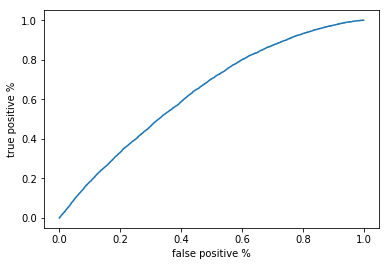

In [85]:
X_train, y_train, X_test, y_test = data_dict["tmp_label2"][0], data_dict["tmp_label2"][1], data_dict["tmp_label2"][2], data_dict["tmp_label2"][3]
rand = clfd.RandomForestClassifier()
rand.set_params(**{'min_samples_split': 10, 'n_jobs': 2, 'class_weight': None, 'random_state': None, 'min_impurity_decrease': 0.0, 'oob_score': False, 'n_estimators': 100, 'verbose': 0, 'criterion': 'gini', 'max_leaf_nodes': None, 'max_depth': 50, 'min_samples_leaf': 1, 'min_impurity_split': None, 'warm_start': False, 'min_weight_fraction_leaf': 0.0, 'max_features': 'sqrt', 'bootstrap': True})
model = rand.fit(X_train, y_train)
y_predp = model.predict_proba(X_test)
eva.depict_ROC(y_test, y_predp)

<Figure size 432x288 with 0 Axes>

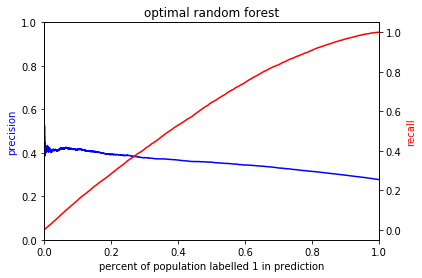

In [86]:
eva.plot_precision_recall_n(y_test, y_predp, "optimal random forest")